In [ ]:
#calculates 20th percentile NDVI for emodis and smodis for long and short rains
#calculates percent error and exports images to Drive
#calculates R^2 of 20th percentiles
#author: Sara Miller

!pip install --upgrade pip --quiet

# try to import packages needed
try:
  import ee
  import folium
  from ee.ee_exception import EEException
  
  from google.colab import auth
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from oauth2client.client import GoogleCredentials


# if it doesn't work, intstall the packages...
except ImportError:
  !pip install -q earthengine-api
  !pip install -q folium
  !pip install -q bokeh
  
  # ...then import
  import ee
  import folium
  from ee.ee_exception import EEException


# import Python packages for utility
import numpy as np
import pandas as pd
import math
import datetime
from itertools import groupby
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
import scipy

In [ ]:
# try to initialize Earth Engine session
try:
  ee.Initialize()

# if it doesn't work, then authorize an account for Earth Engine to connect to...
except EEException:
  !earthengine authenticate --quiet

  authCode = raw_input("Authorization code:")

  !earthengine authenticate --authorization-code=$authCode
  
  # ...then initialize session
  ee.Initialize()

In [ ]:
uai = ee.FeatureCollection('users/sem0029/KLIP_BORANA_CLEAN_2017')

#function to rescale NDVI from 0-200 to -1-1, from sMODIS export code
def rescaleNDVI(img):
  ndvi = img.subtract(100).divide(100).rename('ndvi')
  return ndvi.updateMask(ndvi.gt(-1).And(ndvi.lt(1))).set('system:time_start',img.get('system:time_start'))

#function to mask pixels with limited temporal variability using eMODIS_FEWS_Kenya_dia_BASIS
def imgmask(img):
  mask1 = ee.Image('users/sem0029/mask1').eq(0)
  return img.updateMask(mask1)

#function to add system:time_start to smodis so the collection can be sorted by date
def timestart(img):
  name = img.id()
  year = ee.Number.parse(name.slice(18, 22))
  month = ee.Number.parse(name.slice(22, 24))
  day = ee.Number.parse(name.slice(24))
  date = ee.Date.fromYMD(year,month,day)
  date1 = ee.Date(date).millis()
  return img.set('system:time_start', date1)


#get sMODIS and eMODIS, mask pixels and rescale NDVI
smodis = ee.ImageCollection('users/sem0029/smodis1').map(timestart).map(imgmask).map(rescaleNDVI)
emodis = ee.ImageCollection('users/servirscience/eModis').map(imgmask).map(rescaleNDVI)

#function to convert feature class to pandas dataframe
#from https://gis.stackexchange.com/questions/257727/iterate-over-imagecollection-returning-pandas-dataframe-using-earth-engine-pyt?noredirect=1&lq=1
def fc2df(fc):
  # Convert a FeatureCollection into a pandas DataFrame
  # Features is a list of dict with the output
  features = fc.getInfo()['features']

  dictarr = []

  for f in features:
    # Store all attributes in a dict
    attr = f['properties']
    # and treat geometry separately
    attr['geometry'] = f['geometry']  # GeoJSON Feature!
    # attr['geometrytype'] = f['geometry']['type']
    dictarr.append(attr)

  df = gpd.GeoDataFrame(dictarr)
  # Convert GeoJSON features to shape
  df['geometry'] = map(lambda s: shape(s), df.geometry)    
  return df

In [ ]:
#get 20th percentiles and percent error
#smodis long rains
slongrains = smodis.filter(ee.Filter.calendarRange(2003, 2017, 'year')).filter(ee.Filter.calendarRange(3, 6, 'month'))
slongpercentile = slongrains.reduce(ee.Reducer.percentile([20]))

#smodis short rains
sshortrains = smodis.filter(ee.Filter.calendarRange(2003, 2017, 'year')).filter(ee.Filter.calendarRange(10, 12, 'month'))
sshortpercentile = sshortrains.reduce(ee.Reducer.percentile([20]))

#emodis long rains
elongrains = emodis.filter(ee.Filter.calendarRange(2003, 2017, 'year')).filter(ee.Filter.calendarRange(3, 6, 'month'))
elongpercentile = elongrains.reduce(ee.Reducer.percentile([20]))

#emodis short rains
eshortrains = emodis.filter(ee.Filter.calendarRange(2003, 2017, 'year')).filter(ee.Filter.calendarRange(10, 12, 'month'))
eshortpercentile = eshortrains.reduce(ee.Reducer.percentile([20]))


#long rains percent error
longerror = ((slongpercentile.subtract(elongpercentile)).divide(elongpercentile)).multiply(100)

#short rains percent error
shorterror = ((sshortpercentile.subtract(eshortpercentile)).divide(eshortpercentile)).multiply(100)

#export percent error images to Drive

boxRegion = ee.Geometry.Rectangle([30.5,-6.5,43.5,7.5])
# get serializable geometry for export
exportRegion = boxRegion.bounds().getInfo()['coordinates']
'''
export1 = ee.batch.Export.image.toDrive(image=longerror,
   description = 'longrainspercenterror',
   folder = '20th percentile NDVI/UAI', #change to folder that you want
   region = exportRegion,
   scale = 250,
   crs = 'EPSG:4326',
   maxPixels = 1e13
)
export1.start()

export2 = ee.batch.Export.image.toDrive(image=shorterror,
   description = 'shortrainspercenterror',
   folder = '20th percentile NDVI/UAI', #change to folder that you want
   region = exportRegion,
   scale = 250,
   crs = 'EPSG:4326',
   maxPixels = 1e13
)
export2.start()'''

Long Rains R^2:
0.9742980438373221
Short Rains R^2:
0.9731108617502617


Text(0.5,1,'Short Rains')

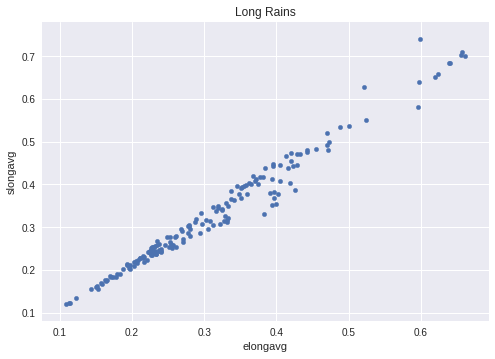

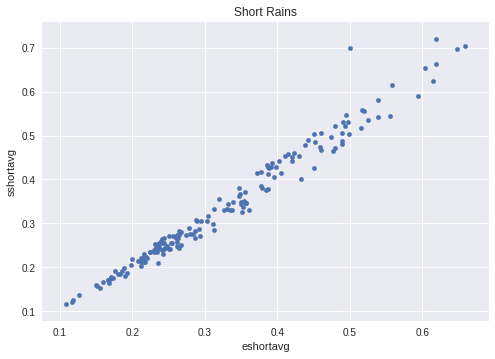

In [ ]:
#get scatterplot and R^2 value for 20th percentile averages per UAI

#set up empty dataframe
df = pd.DataFrame()

#smodis long rains per uai
slonguai = slongpercentile.reduceRegions(collection=uai, reducer=ee.Reducer.mean(), scale=250)#get mean per UAI
#convert the results from Reduce.Regions into a dataframe
sdf1 = fc2df(slonguai)
#add columns to the dataframe
df['slongavg'] = sdf1['mean']

#smodis short rains per uai
sshortuai = sshortpercentile.reduceRegions(collection=uai, reducer=ee.Reducer.mean(), scale=250)#get mean per UAI
#convert the results from Reduce.Regions into a dataframe
sdf2 = fc2df(sshortuai)
#add columns to the dataframe
df['sshortavg'] = sdf2['mean']


#emodis long rains per uai
elonguai = elongpercentile.reduceRegions(collection=uai, reducer=ee.Reducer.mean(), scale=250)#get mean per UAI
#convert the results from Reduce.Regions into a dataframe
edf1 = fc2df(elonguai)
#add columns to the dataframe
df['elongavg'] = edf1['mean']

#emodis short rains per uai
eshortuai = eshortpercentile.reduceRegions(collection=uai, reducer=ee.Reducer.mean(), scale=250)#get mean per UAI
#convert the results from Reduce.Regions into a dataframe
edf2 = fc2df(eshortuai)
#add columns to the dataframe
df['eshortavg'] = edf2['mean']


#set index of the dataframe to UAI gridcode
df['gridcode'] = sdf1['gridcode']
df.set_index('gridcode', inplace=True, drop=True)


#calculate R^2
def rsquared(x, y):
  """ Return R^2 where x and y are array-like."""

  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
  return r_value**2

rsquarelr = rsquared(df['elongavg'], df['slongavg'])
rsquaresr = rsquared(df['eshortavg'], df['sshortavg'])


#display R^2 and scatterplots
print('Long Rains R^2:')
print(rsquarelr)
df.plot.scatter(x='elongavg', y='slongavg').set_title('Long Rains')

print('Short Rains R^2:')
print(rsquaresr)
df.plot.scatter(x='eshortavg', y='sshortavg').set_title('Short Rains')